In [46]:
%matplotlib inline
%load_ext autoreload


import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import average_precision_score
from tree_explainer.tree_explainer import TreeExplainer


# Load data
data = load_breast_cancer()
X = data['data']
y = data['target']
feature_names = data['feature_names']
target_names = data['target_names']


SEED = 17
N_JOBS = -1
VERBOSE = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Split data in training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.20, random_state=SEED)

In [3]:
# Train RandomForest
n_trees = 1000

RF = RandomForestClassifier(n_estimators=n_trees, random_state=SEED, n_jobs=-1)
RF.fit(X_train, y_train)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 10 µs


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=300,
                       n_jobs=-1, oob_score=False, random_state=17, verbose=0,
                       warm_start=False)

In [4]:
# Initialize TreeExplainer
TE = TreeExplainer(RF, feature_names=feature_names, target_names=target_names,
                   n_jobs=N_JOBS, verbose=VERBOSE)

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.25 µs


In [18]:
# TE contains several information on the trees structure. For example, the features used at each split. 
fp = TE.tree_feature_path

print('Length of tree_feature_path: %s' % len(fp))  # This is equal to the number of trees

# Show the first branch of the first tree, that is fp[0][0], as
# a list of features, from the tree root (at the first split) down to a leaf
print('\nFirst branch of first tree')
[TE.feature_names[i] for i in fp[0][0]]

Length of tree_feature_path: 300

First branch of first tree


['mean concave points',
 'mean radius',
 'worst area',
 'worst perimeter',
 'worst texture',
 'fractal dimension error',
 'worst symmetry']

In [49]:
# Predict and explain_feature_contributions feature contributions to test data
TE.explain_feature_contributions(X_test, y_test, compute_conditional_contributions=True,
                   n_jobs=N_JOBS, verbose=VERBOSE)

print('Precision-recall AUC score: %.4f' % average_precision_score(y_test, TE.predictions))

Average precision: 0.9656


In [6]:
# Tabulate contributions to the class 'malignant'
df = pd.DataFrame(TE.contributions[:, :, 0], columns=TE.feature_names)
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,-0.022786,-0.001927,-0.017546,-0.017455,-0.004420,-0.000811,0.033781,-0.041840,-0.000875,-0.000683,...,-0.053046,-0.001390,-0.061141,-0.044292,-0.004443,-0.004830,-0.002315,-0.045393,-0.001451,-0.001798
1,-0.016141,-0.001192,-0.011962,-0.015035,-0.000110,-0.001972,-0.022588,-0.044834,0.000003,-0.000155,...,-0.035066,-0.000771,-0.049745,-0.033090,-0.000487,-0.002869,-0.012692,-0.034690,-0.000254,-0.001072
2,-0.016141,-0.001192,-0.011962,-0.015035,-0.000110,-0.001972,-0.022588,-0.044834,0.000003,-0.000155,...,-0.035066,-0.000771,-0.049745,-0.033090,-0.000487,-0.002591,-0.012692,-0.034690,-0.000254,-0.001072
3,-0.015434,-0.001192,-0.012033,-0.015446,-0.000501,-0.001972,-0.022588,-0.045117,0.000003,-0.000086,...,-0.034545,-0.000605,-0.049699,-0.033507,-0.001166,-0.002940,-0.012898,-0.034378,-0.001115,-0.001072
4,-0.016074,-0.001192,-0.011962,-0.015020,-0.000110,-0.001972,-0.022588,-0.044406,0.000003,-0.000155,...,-0.036618,-0.000756,-0.049973,-0.033090,-0.000672,-0.002852,-0.012692,-0.034373,-0.001419,-0.001072


In [7]:
# Tabulate contributions to first observation
df = pd.DataFrame(TE.contributions[0, :, :], index=TE.feature_names, columns=TE.target_names)

df.sort_values(by='malignant', ascending=False).head()

,malignant,benign
mean concavity,0.033781,-0.033781
perimeter error,0.004116,-0.004116
concavity error,0.000896,-0.000896
concave points error,0.000629,-0.000629
texture error,0.000062,-0.000062


In [8]:
df.sort_values(by='benign', ascending=False).head()

,malignant,benign
worst perimeter,-0.061141,0.061141
worst radius,-0.053046,0.053046
worst concave points,-0.045393,0.045393
worst area,-0.044292,0.044292
mean concave points,-0.041840,0.041840


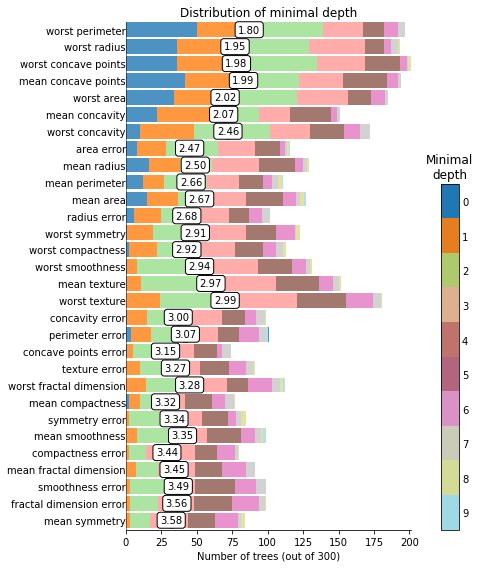

In [43]:
TE.plot_min_depth_distribution()

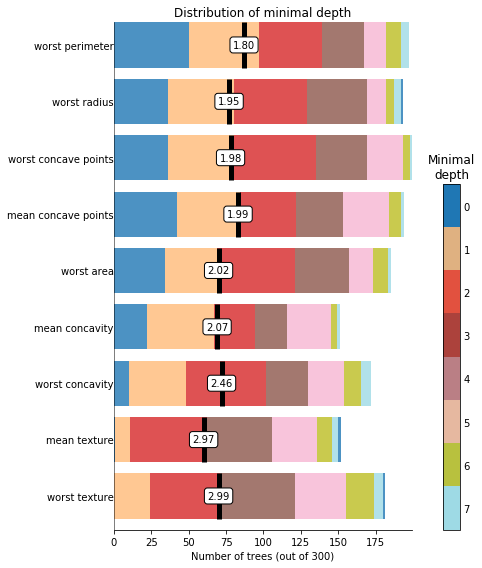

In [42]:
TE.plot_min_depth_distribution(min_trees_fraction=.5)

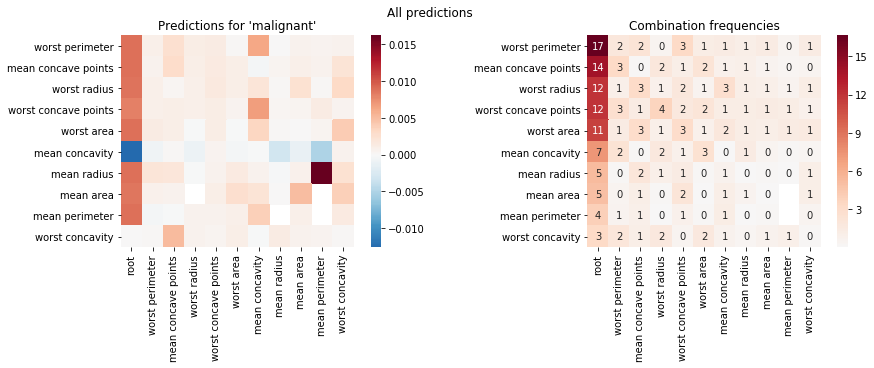

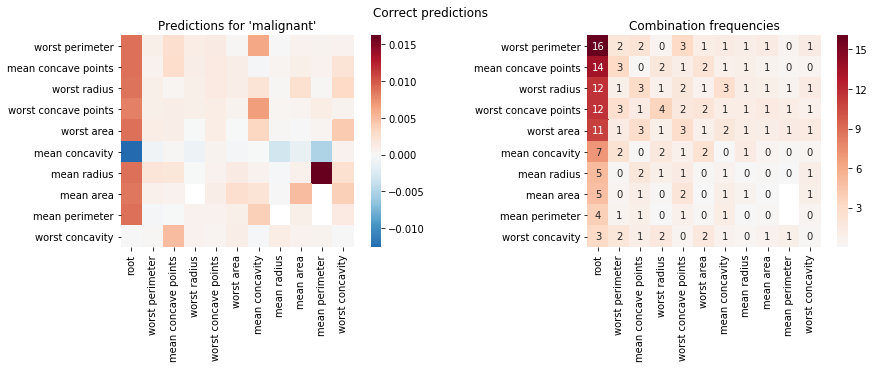

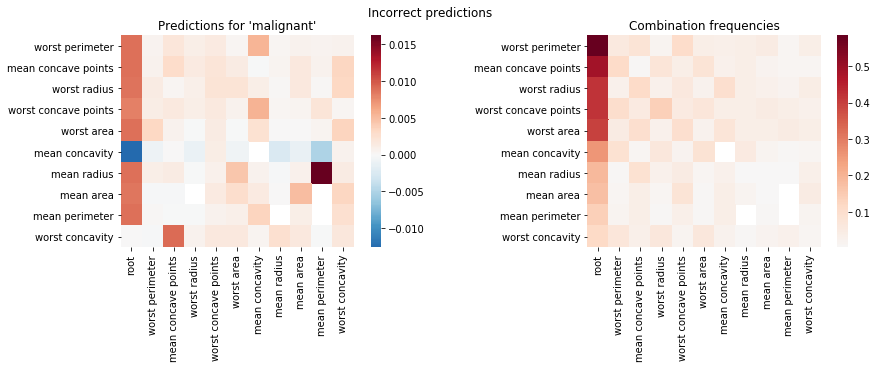

In [45]:
TE.plot_two_way_interactions(sort_features_on_target='malignant', 
                             sort_on_contributions=False, top_n_features=10)